In [1]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn

# 1. Faza grupowa i faza pucharowa

### 1.1. Wczytanie i czyszczenie danych

In [3]:
results = pd.read_csv('python dane.csv')
results.head()

,Round,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee
0,Group stage,1.0,Sun,2022-11-20,19:00 (17:00),Qatar qa,0.3,0–2,1.2,ec Ecuador,67372,Al Bayt Stadium (Neutral Site),Daniele Orsato
1,Group stage,1.0,Mon,2022-11-21,16:00 (14:00),England eng,2.1,6–2,1.4,ir IR Iran,45334,Khalifa International Stadium (Neutral Site),Raphael Claus
2,Group stage,1.0,Mon,2022-11-21,19:00 (17:00),Senegal sn,0.9,0–2,0.7,nl Netherlands,41721,Al Thumama Stadium (Neutral Site),Wilton Sampaio
3,Group stage,1.0,Mon,2022-11-21,22:00 (20:00),United States us,0.8,1–1,1.5,wls Wales,43418,Ahmed bin Ali Stadium (Neutral Site),Abdulrahman Ibrahim Al Jassim
4,Group stage,1.0,Tue,2022-11-22,13:00 (11:00),Argentina ar,2.2,1–2,0.1,sa Saudi Arabia,88012,Lusail Iconic Stadium (Neutral Site),Slavko Vinčič


In [4]:
results.insert(8, 'Penalties', [str(s[1]) + '-' + str(s[-2]) if '(' in s else '-' for s in results['Score']])
results['Score'] = [s[4:7] if '(' in s else s[:] for s in results['Score']]
results.insert(7, 'Home_Score', [int(s[:1]) for s in results['Score']])
results.insert(8, 'Away_Score', [int(s[-1:]) for s in results['Score']])
results['Venue'] = [x.replace(' (Neutral Site)', '') for x in results['Venue']]

In [5]:
print(results['Home'].unique())
print(results['Away'].unique())
results['Home'] = [h[:-3] for h in results['Home']]
results['Away'] = [a[3:] for a in results['Away']]
results['Home'] = [h[3:] if 'IR' in h else h for h in results['Home']]
results['Away'] = [a[3:] if 'IR' in a else a for a in results['Away']]
results['Home'] = [h.strip() for h in results['Home']]
results['Away'] = [a.strip() for a in results['Away']]
print(results['Home'].unique())
print(results['Away'].unique())

['Qatar qa' 'England eng' 'Senegal sn' 'United States us' 'Argentina ar'
 'Denmark dk' 'Mexico mx' 'France fr' 'Morocco ma' 'Germany de' 'Spain es'
 'Belgium be' 'Switzerland ch' 'Uruguay uy' 'Portugal pt' 'Brazil br'
 'Wales wls' 'Netherlands nl' 'Tunisia tn' 'Poland pl' 'Japan jp'
 'Croatia hr' 'Cameroon cm' 'Korea Republic kr' 'Ecuador ec' 'IR Iran ir'
 'Australia au' 'Saudi Arabia sa' 'Canada ca' 'Costa Rica cr' 'Ghana gh'
 'Serbia rs']
['ec Ecuador' 'ir IR Iran' 'nl Netherlands' 'wls Wales' 'sa Saudi Arabia'
 'tn Tunisia' 'pl Poland' 'au Australia' 'hr Croatia' 'jp Japan'
 'cr Costa Rica' 'ca Canada' 'cm Cameroon' 'kr Korea Republic' 'gh Ghana'
 'rs Serbia' 'sn Senegal' 'us United States' 'dk Denmark' 'mx Mexico'
 'ma Morocco' 'de Germany' 'ch Switzerland' 'uy Uruguay' 'qa Qatar'
 'eng England' 'fr France' 'ar Argentina' 'be Belgium' 'es Spain'
 'pt Portugal' 'br Brazil']
['Qatar' 'England' 'Senegal' 'United States' 'Argentina' 'Denmark'
 'Mexico' 'France' 'Morocco' 'Germany' 'Spa

In [6]:
results.dtypes

Round          object
Wk            float64
Day            object
Date           object
Time           object
Home           object
xG            float64
Home_Score      int64
Away_Score      int64
Score          object
Penalties      object
xG.1          float64
Away           object
Attendance      int64
Venue          object
Referee        object
dtype: object

In [7]:
results.head()

,Round,Wk,Day,Date,Time,Home,xG,Home_Score,Away_Score,Score,Penalties,xG.1,Away,Attendance,Venue,Referee
0,Group stage,1.0,Sun,2022-11-20,19:00 (17:00),Qatar,0.3,0,2,0–2,-,1.2,Ecuador,67372,Al Bayt Stadium,Daniele Orsato
1,Group stage,1.0,Mon,2022-11-21,16:00 (14:00),England,2.1,6,2,6–2,-,1.4,Iran,45334,Khalifa International Stadium,Raphael Claus
2,Group stage,1.0,Mon,2022-11-21,19:00 (17:00),Senegal,0.9,0,2,0–2,-,0.7,Netherlands,41721,Al Thumama Stadium,Wilton Sampaio
3,Group stage,1.0,Mon,2022-11-21,22:00 (20:00),United States,0.8,1,1,1–1,-,1.5,Wales,43418,Ahmed bin Ali Stadium,Abdulrahman Ibrahim Al Jassim
4,Group stage,1.0,Tue,2022-11-22,13:00 (11:00),Argentina,2.2,1,2,1–2,-,0.1,Saudi Arabia,88012,Lusail Iconic Stadium,Slavko Vinčič


In [8]:
group_stage_results = results.loc[results['Round'] == 'Group stage']
knockout_stage_results = results.loc[results['Round'] != 'Group stage']

### 1.2. Łączenie danych

In [9]:
groups_dict = {'A' : ['Qatar', 'Senegal', 'Netherlands', 'Ecuador'],
              'B' : ['England', 'United States', 'Iran', 'Wales'],
              'C' : ['Argentina', 'Poland', 'Mexico', 'Saudi Arabia'],
              'D' : ['France', 'Australia', 'Tunisia', 'Denmark'],
              'E' : ['Japan', 'Spain', 'Germany', 'Costa Rica'],
              'F' : ['Morocco', 'Croatia', 'Belgium', 'Canada'],
              'G' : ['Brazil', 'Switzerland', 'Cameroon', 'Serbia'],
              'H' : ['Portugal', 'Korea Republic', 'Uruguay', 'Ghana']}
df_groups = pd.DataFrame(groups_dict).melt()
df_groups.columns = ['Group', 'Team']
df_groups2 = df_groups.copy()
df_groups2.set_index('Team', inplace = True)
groups_dict_to_map = df_groups2.to_dict()['Group']
groups_dict_to_map

{'Qatar': 'A',
 'Senegal': 'A',
 'Netherlands': 'A',
 'Ecuador': 'A',
 'England': 'B',
 'United States': 'B',
 'Iran': 'B',
 'Wales': 'B',
 'Argentina': 'C',
 'Poland': 'C',
 'Mexico': 'C',
 'Saudi Arabia': 'C',
 'France': 'D',
 'Australia': 'D',
 'Tunisia': 'D',
 'Denmark': 'D',
 'Japan': 'E',
 'Spain': 'E',
 'Germany': 'E',
 'Costa Rica': 'E',
 'Morocco': 'F',
 'Croatia': 'F',
 'Belgium': 'F',
 'Canada': 'F',
 'Brazil': 'G',
 'Switzerland': 'G',
 'Cameroon': 'G',
 'Serbia': 'G',
 'Portugal': 'H',
 'Korea Republic': 'H',
 'Uruguay': 'H',
 'Ghana': 'H'}

In [10]:
group_stage_results = group_stage_results.merge(df_groups, how = 'left', left_on = 'Home', right_on = 'Team')
group_stage_results.drop(columns = 'Team', inplace = True)
group_stage_results = group_stage_results[group_stage_results.columns.to_list()[:5] +
                                          group_stage_results.columns.to_list()[-1:] +
                                          group_stage_results.columns.to_list()[5:-1]]
group_stage_results.head()

,Round,Wk,Day,Date,Time,Group,Home,xG,Home_Score,Away_Score,Score,Penalties,xG.1,Away,Attendance,Venue,Referee
0,Group stage,1.0,Sun,2022-11-20,19:00 (17:00),A,Qatar,0.3,0,2,0–2,-,1.2,Ecuador,67372,Al Bayt Stadium,Daniele Orsato
1,Group stage,1.0,Mon,2022-11-21,16:00 (14:00),B,England,2.1,6,2,6–2,-,1.4,Iran,45334,Khalifa International Stadium,Raphael Claus
2,Group stage,1.0,Mon,2022-11-21,19:00 (17:00),A,Senegal,0.9,0,2,0–2,-,0.7,Netherlands,41721,Al Thumama Stadium,Wilton Sampaio
3,Group stage,1.0,Mon,2022-11-21,22:00 (20:00),B,United States,0.8,1,1,1–1,-,1.5,Wales,43418,Ahmed bin Ali Stadium,Abdulrahman Ibrahim Al Jassim
4,Group stage,1.0,Tue,2022-11-22,13:00 (11:00),C,Argentina,2.2,1,2,1–2,-,0.1,Saudi Arabia,88012,Lusail Iconic Stadium,Slavko Vinčič


### 1.3. Stworzenie ogólnej tabeli

In [11]:
teams = results['Home'].unique()
table = {'Group': [0] * len(teams),
         'Team' : teams,
         'Played' : [0] * len(teams),
         'Won' : [0] * len(teams), 
         'Drawn' : [0] * len(teams), 
         'Lost' : [0] * len(teams), 
         'GF' : [0] * len(teams), 
         'GA' : [0] * len(teams), 
         'GD' : [0] * len(teams),
         'Points' : [0] * len(teams)}
table = pd.DataFrame(table)
for index, row in group_stage_results.iterrows():
    home_team = row['Home']
    away_team = row['Away']
    home_score = row['Home_Score']
    away_score = row['Away_Score']
    table.loc[table['Team'] == home_team, ['Played', 'GF', 'GA']] += [1, home_score, away_score]
    table.loc[table['Team'] == away_team, ['Played', 'GF', 'GA']] += [1, away_score, home_score]
    if home_score > away_score:
        table.loc[table['Team'] == home_team,['Points', 'Won']] += [3, 1]
        table.loc[table['Team'] == away_team,['Lost']] += 1
    elif home_score < away_score:
        table.loc[table['Team'] == away_team,['Points','Won']] += [3, 1]
        table.loc[table['Team'] == home_team,['Lost']] += 1
    else:
        table.loc[table['Team'] == home_team,['Points', 'Drawn']] += [1, 1]
        table.loc[table['Team'] == away_team,['Points', 'Drawn']] += [1, 1]
table['GD'] = table['GF'] - table['GA']
table['Group'] = table['Team']
table['Group'] = table['Group'].map(groups_dict_to_map)
table

,Group,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
0,A,Qatar,3,0,0,3,1,7,-6,0
1,B,England,3,2,1,0,9,2,7,7
2,A,Senegal,3,2,0,1,5,4,1,6
3,B,United States,3,1,2,0,2,1,1,5
4,C,Argentina,3,2,0,1,5,2,3,6
5,D,Denmark,3,0,1,2,1,3,-2,1
6,C,Mexico,3,1,1,1,2,3,-1,4
7,D,France,3,2,0,1,6,3,3,6
8,F,Morocco,3,2,1,0,4,1,3,7
9,E,Germany,3,1,1,1,6,5,1,4


### 1.4. Podział na konkretne grupy

In [12]:
def group_partition(group):
    gr = table.loc[table['Group'] == group]
    gr.sort_values(by = ['Points', 'GD'], ascending = False, inplace = True)
    gr.reset_index(inplace = True)
    gr.drop(['Group', 'index'], axis = 1, inplace = True)
    gr.index += 1
    gr.index.name = 'Group ' + str(group)
    return gr

group_A = group_partition('A')
group_B = group_partition('B')
group_C = group_partition('C')
group_D = group_partition('D')
group_E = group_partition('E')
group_F = group_partition('F')
group_G = group_partition('G')
group_H = group_partition('H')

group_A

,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
Group A,,,,,,,,,
1,Netherlands,3,2,1,0,5,1,4,7
2,Senegal,3,2,0,1,5,4,1,6
3,Ecuador,3,1,1,1,4,3,1,4
4,Qatar,3,0,0,3,1,7,-6,0


### 1.5. Podział na konkretne etapy fazy pucharowej

In [13]:
knockout_stage_results.head()

,Round,Wk,Day,Date,Time,Home,xG,Home_Score,Away_Score,Score,Penalties,xG.1,Away,Attendance,Venue,Referee
48,Round of 16,NaN,Sat,2022-12-03,18:00 (16:00),Netherlands,1.7,3,1,3–1,-,1.5,United States,44846,Khalifa International Stadium,Wilton Sampaio
49,Round of 16,NaN,Sat,2022-12-03,22:00 (20:00),Argentina,1.6,2,1,2–1,-,0.6,Australia,45032,Ahmed bin Ali Stadium,Szymon Marciniak
50,Round of 16,NaN,Sun,2022-12-04,18:00 (16:00),France,1.4,3,1,3–1,-,1.7,Poland,40989,Al Thumama Stadium,Jesús Valenzuela
51,Round of 16,NaN,Sun,2022-12-04,22:00 (20:00),England,1.0,3,0,3–0,-,0.8,Senegal,65985,Al Bayt Stadium,Iván Barton
52,Round of 16,NaN,Mon,2022-12-05,18:00 (16:00),Japan,1.2,1,1,1–1,1-3,1.4,Croatia,42523,Al Janoub Stadium,Ismail Elfath


In [14]:
unique_stages = knockout_stage_results['Round'].unique()
def stage_sum(unique_stage):
    stage = knockout_stage_results.loc[knockout_stage_results['Round'] == unique_stage]
    stage['Score'] = stage.apply(lambda x: str(x['Score']) + ' (pen. ' + str(x['Penalties']) + ')' if x['Penalties'] != '-' else x['Score'], axis = 1)
    stage = stage.drop(['Wk', 'Day', 'Time', 'xG', 'Home_Score', 'Away_Score', 'Penalties', 'xG.1'], axis = 1).reset_index().drop('index', axis = 1)
    return stage
round_of_16 = stage_sum(unique_stages[0])
quater = stage_sum(unique_stages[1])
semi = stage_sum(unique_stages[2])
finals = pd.concat([stage_sum(unique_stages[3]), stage_sum(unique_stages[4])])

round_of_16

,Round,Date,Home,Score,Away,Attendance,Venue,Referee
0,Round of 16,2022-12-03,Netherlands,3–1,United States,44846,Khalifa International Stadium,Wilton Sampaio
1,Round of 16,2022-12-03,Argentina,2–1,Australia,45032,Ahmed bin Ali Stadium,Szymon Marciniak
2,Round of 16,2022-12-04,France,3–1,Poland,40989,Al Thumama Stadium,Jesús Valenzuela
3,Round of 16,2022-12-04,England,3–0,Senegal,65985,Al Bayt Stadium,Iván Barton
4,Round of 16,2022-12-05,Japan,1–1 (pen. 1-3),Croatia,42523,Al Janoub Stadium,Ismail Elfath
5,Round of 16,2022-12-05,Brazil,4–1,Korea Republic,43847,Stadium 974,Clément Turpin
6,Round of 16,2022-12-06,Morocco,0–0 (pen. 3-0),Spain,44667,Education City Stadium,Fernando Rapallini
7,Round of 16,2022-12-06,Portugal,6–1,Switzerland,83720,Lusail Iconic Stadium,César Arturo Ramos


### 1.6. Wyświetlenie ostatecznych danych

In [15]:
display(group_A)
display(group_B)
display(group_C)
display(group_D)
display(group_E)
display(group_F)
display(group_G)
display(group_H)

,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
Group A,,,,,,,,,
1,Netherlands,3,2,1,0,5,1,4,7
2,Senegal,3,2,0,1,5,4,1,6
3,Ecuador,3,1,1,1,4,3,1,4
4,Qatar,3,0,0,3,1,7,-6,0


,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
Group B,,,,,,,,,
1,England,3,2,1,0,9,2,7,7
2,United States,3,1,2,0,2,1,1,5
3,Iran,3,1,0,2,4,7,-3,3
4,Wales,3,0,1,2,1,6,-5,1


,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
Group C,,,,,,,,,
1,Argentina,3,2,0,1,5,2,3,6
2,Poland,3,1,1,1,2,2,0,4
3,Mexico,3,1,1,1,2,3,-1,4
4,Saudi Arabia,3,1,0,2,3,5,-2,3


,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
Group D,,,,,,,,,
1,France,3,2,0,1,6,3,3,6
2,Australia,3,2,0,1,3,4,-1,6
3,Tunisia,3,1,1,1,1,1,0,4
4,Denmark,3,0,1,2,1,3,-2,1


,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
Group E,,,,,,,,,
1,Japan,3,2,0,1,4,3,1,6
2,Spain,3,1,1,1,9,3,6,4
3,Germany,3,1,1,1,6,5,1,4
4,Costa Rica,3,1,0,2,3,11,-8,3


,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
Group F,,,,,,,,,
1,Morocco,3,2,1,0,4,1,3,7
2,Croatia,3,1,2,0,4,1,3,5
3,Belgium,3,1,1,1,1,2,-1,4
4,Canada,3,0,0,3,2,7,-5,0


,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
Group G,,,,,,,,,
1,Brazil,3,2,0,1,3,1,2,6
2,Switzerland,3,2,0,1,4,3,1,6
3,Cameroon,3,1,1,1,4,4,0,4
4,Serbia,3,0,1,2,5,8,-3,1


,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
Group H,,,,,,,,,
1,Portugal,3,2,0,1,6,4,2,6
2,Uruguay,3,1,1,1,2,2,0,4
3,Korea Republic,3,1,1,1,4,4,0,4
4,Ghana,3,1,0,2,5,7,-2,3


In [16]:
display(round_of_16)
display(quater)
display(semi)
display(finals)

,Round,Date,Home,Score,Away,Attendance,Venue,Referee
0,Round of 16,2022-12-03,Netherlands,3–1,United States,44846,Khalifa International Stadium,Wilton Sampaio
1,Round of 16,2022-12-03,Argentina,2–1,Australia,45032,Ahmed bin Ali Stadium,Szymon Marciniak
2,Round of 16,2022-12-04,France,3–1,Poland,40989,Al Thumama Stadium,Jesús Valenzuela
3,Round of 16,2022-12-04,England,3–0,Senegal,65985,Al Bayt Stadium,Iván Barton
4,Round of 16,2022-12-05,Japan,1–1 (pen. 1-3),Croatia,42523,Al Janoub Stadium,Ismail Elfath
5,Round of 16,2022-12-05,Brazil,4–1,Korea Republic,43847,Stadium 974,Clément Turpin
6,Round of 16,2022-12-06,Morocco,0–0 (pen. 3-0),Spain,44667,Education City Stadium,Fernando Rapallini
7,Round of 16,2022-12-06,Portugal,6–1,Switzerland,83720,Lusail Iconic Stadium,César Arturo Ramos


,Round,Date,Home,Score,Away,Attendance,Venue,Referee
0,Quarter-finals,2022-12-09,Croatia,1–1 (pen. 4-2),Brazil,43893,Education City Stadium,Michael Oliver
1,Quarter-finals,2022-12-09,Netherlands,2–2 (pen. 3-4),Argentina,88235,Lusail Iconic Stadium,Antonio Matéu
2,Quarter-finals,2022-12-10,Morocco,1–0,Portugal,44198,Al Thumama Stadium,Facundo Tello
3,Quarter-finals,2022-12-10,England,1–2,France,68895,Al Bayt Stadium,Wilton Sampaio


,Round,Date,Home,Score,Away,Attendance,Venue,Referee
0,Semi-finals,2022-12-13,Argentina,3–0,Croatia,88966,Lusail Iconic Stadium,Daniele Orsato
1,Semi-finals,2022-12-14,France,2–0,Morocco,68294,Al Bayt Stadium,César Arturo Ramos


,Round,Date,Home,Score,Away,Attendance,Venue,Referee
0,Third-place match,2022-12-17,Croatia,2–1,Morocco,44137,Khalifa International Stadium,Abdulrahman Ibrahim Al Jassim
0,Final,2022-12-18,Argentina,3–3 (pen. 4-2),France,88966,Lusail Iconic Stadium,Szymon Marciniak


#  2. Statystyki zawodników

### 2.1. Wczytanie i czyszczenie danych

In [17]:
stats1 = pd.read_csv('dane1.csv')
stats2 = pd.read_csv('dane2.csv')
display(stats1.head())
display(stats2.head())

,Rk,Player,Pos,Squad,Age,Club,Born,MP,Starts,Min,...,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,Matches,-9999
0,1,Brenden Aaronson,MF,us United States,21,1.eng Leeds United,2000,4,0,108,...,0.1,0.2,0.3,0.06,0.18,0.24,0.06,0.24,Matches,5bc43860
1,2,Ali Abdi,DF,tn Tunisia,28,2.fr Caen,1993,3,2,188,...,0.0,0.0,0.0,0.00,0.02,0.02,0.00,0.02,Matches,ad7cdb35
2,3,Salis Abdul Samed,MF,gh Ghana,22,1.fr Lens,2000,3,3,250,...,0.0,0.0,0.1,0.01,0.01,0.02,0.01,0.02,Matches,82464ce3
3,4,Saud Abdulhamid,DFMF,sa Saudi Arabia,22,1.sa Al-Hilal,1999,3,3,270,...,0.0,0.0,0.1,0.01,0.02,0.02,0.01,0.02,Matches,caa254e4
4,5,Nawaf Al Abed,MF,sa Saudi Arabia,32,1.sa Al-Shabab,1990,2,0,88,...,0.1,0.1,0.2,0.13,0.06,0.20,0.13,0.20,Matches,bfef5c87


,Rk,Player,Pos,Squad,Age,Born,90s,Gls,Sh,SoT,...,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Matches,-9999
0,1,Brenden Aaronson,MF,us United States,21,2000,1.2,0,1,0,...,0.0,0,0,0.1,0.1,0.07,-0.1,-0.1,Matches,5bc43860
1,2,Ali Abdi,DF,tn Tunisia,28,1993,2.1,0,0,0,...,0.0,0,0,0.0,0.0,NaN,0.0,0.0,Matches,ad7cdb35
2,3,Salis Abdul Samed,MF,gh Ghana,22,2000,2.8,0,1,0,...,0.0,0,0,0.0,0.0,0.02,0.0,0.0,Matches,82464ce3
3,4,Saud Abdulhamid,DFMF,sa Saudi Arabia,22,1999,3.0,0,1,0,...,0.0,0,0,0.0,0.0,0.02,0.0,0.0,Matches,caa254e4
4,5,Nawaf Al Abed,MF,sa Saudi Arabia,32,1990,1.0,0,2,0,...,1.0,0,0,0.1,0.1,0.07,-0.1,-0.1,Matches,bfef5c87


In [18]:
print(stats1.columns)
stats1.drop(['Rk', 'Starts', '90s', 'G-PK', 'Gls.1', 'Ast.1', 'G+A', 'G-PK.1', 'G+A-PK', 'xG', 'npxG', 'xAG', 
             'npxG+xAG', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1', 'npxG+xAG.1', 'Matches', '-9999'], axis = 1, inplace = True)
stats1.head()

Index(['Rk', 'Player', 'Pos', 'Squad', 'Age', 'Club', 'Born', 'MP', 'Starts',
       'Min', '90s', 'Gls', 'Ast', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR',
       'Gls.1', 'Ast.1', 'G+A', 'G-PK.1', 'G+A-PK', 'xG', 'npxG', 'xAG',
       'npxG+xAG', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1', 'npxG+xAG.1',
       'Matches', '-9999'],
      dtype='object')


,Player,Pos,Squad,Age,Club,Born,MP,Min,Gls,Ast,PK,PKatt,CrdY,CrdR
0,Brenden Aaronson,MF,us United States,21,1.eng Leeds United,2000,4,108,0,0,0,0,0,0
1,Ali Abdi,DF,tn Tunisia,28,2.fr Caen,1993,3,188,0,0,0,0,1,0
2,Salis Abdul Samed,MF,gh Ghana,22,1.fr Lens,2000,3,250,0,0,0,0,0,0
3,Saud Abdulhamid,DFMF,sa Saudi Arabia,22,1.sa Al-Hilal,1999,3,270,0,0,0,0,1,0
4,Nawaf Al Abed,MF,sa Saudi Arabia,32,1.sa Al-Shabab,1990,2,88,0,0,0,0,1,0


In [19]:
print(stats2.columns)
stats2.drop(['Rk', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Gls', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT',
             'Dist', 'FK', 'PK', 'PKatt', 'npxG', 'npxG/Sh', 'G-xG', 'np:G-xG', 'Matches', '-9999'], axis = 1, inplace = True)
stats2.head()

Index(['Rk', 'Player', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Gls', 'Sh',
       'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'FK', 'PK',
       'PKatt', 'xG', 'npxG', 'npxG/Sh', 'G-xG', 'np:G-xG', 'Matches',
       '-9999'],
      dtype='object')


,Player,Sh,SoT,xG
0,Brenden Aaronson,1,0,0.1
1,Ali Abdi,0,0,0.0
2,Salis Abdul Samed,1,0,0.0
3,Saud Abdulhamid,1,0,0.0
4,Nawaf Al Abed,2,0,0.1


In [20]:
stats = stats1.merge(stats2, how = 'left', left_on = 'Player', right_on = 'Player')
stats.head()

,Player,Pos,Squad,Age,Club,Born,MP,Min,Gls,Ast,PK,PKatt,CrdY,CrdR,Sh,SoT,xG
0,Brenden Aaronson,MF,us United States,21,1.eng Leeds United,2000,4,108,0,0,0,0,0,0,1,0,0.1
1,Ali Abdi,DF,tn Tunisia,28,2.fr Caen,1993,3,188,0,0,0,0,1,0,0,0,0.0
2,Salis Abdul Samed,MF,gh Ghana,22,1.fr Lens,2000,3,250,0,0,0,0,0,0,1,0,0.0
3,Saud Abdulhamid,DFMF,sa Saudi Arabia,22,1.sa Al-Hilal,1999,3,270,0,0,0,0,1,0,1,0,0.0
4,Nawaf Al Abed,MF,sa Saudi Arabia,32,1.sa Al-Shabab,1990,2,88,0,0,0,0,1,0,2,0,0.1


In [21]:
print(stats['Pos'].nunique())
stats['Pos'] = [x[:2] for x in stats['Pos']]
print(stats['Pos'].nunique())

print(stats['Squad'].unique())
stats['Squad'] = [x[(x.find(' ') + 1):] for x in stats['Squad']]
stats['Squad'] = [x[3:] if x == 'IR Iran' else x for x in stats['Squad']]
print(stats['Squad'].unique())

stats.rename(columns = {'Gls':'Goals', 'Ast' : 'Assists', 'CrdY' : 'Yellow_cards', 'CrdR' : 'Red_cards', 'Min' : 'Minutes'}, inplace = True)
stats.head()

10
4
['us United States' 'tn Tunisia' 'gh Ghana' 'sa Saudi Arabia' 'sn Senegal'
 'cm Cameroon' 'ma Morocco' 'ar Argentina' 'ca Canada' 'ch Switzerland'
 'qa Qatar' 'cr Costa Rica' 'nl Netherlands' 'es Spain' 'be Belgium'
 'eng England' 'br Brazil' 'wls Wales' 'mx Mexico' 'dk Denmark'
 'ir IR Iran' 'jp Japan' 'au Australia' 'rs Serbia' 'hr Croatia'
 'pl Poland' 'uy Uruguay' 'ec Ecuador' 'fr France' 'pt Portugal'
 'kr Korea Republic' 'de Germany']
['United States' 'Tunisia' 'Ghana' 'Saudi Arabia' 'Senegal' 'Cameroon'
 'Morocco' 'Argentina' 'Canada' 'Switzerland' 'Qatar' 'Costa Rica'
 'Netherlands' 'Spain' 'Belgium' 'England' 'Brazil' 'Wales' 'Mexico'
 'Denmark' 'Iran' 'Japan' 'Australia' 'Serbia' 'Croatia' 'Poland'
 'Uruguay' 'Ecuador' 'France' 'Portugal' 'Korea Republic' 'Germany']


,Player,Pos,Squad,Age,Club,Born,MP,Minutes,Goals,Assists,PK,PKatt,Yellow_cards,Red_cards,Sh,SoT,xG
0,Brenden Aaronson,MF,United States,21,1.eng Leeds United,2000,4,108,0,0,0,0,0,0,1,0,0.1
1,Ali Abdi,DF,Tunisia,28,2.fr Caen,1993,3,188,0,0,0,0,1,0,0,0,0.0
2,Salis Abdul Samed,MF,Ghana,22,1.fr Lens,2000,3,250,0,0,0,0,0,0,1,0,0.0
3,Saud Abdulhamid,DF,Saudi Arabia,22,1.sa Al-Hilal,1999,3,270,0,0,0,0,1,0,1,0,0.0
4,Nawaf Al Abed,MF,Saudi Arabia,32,1.sa Al-Shabab,1990,2,88,0,0,0,0,1,0,2,0,0.1


### 2.2. Analiza poszczególnych statystyk u zawodników

In [22]:
most_goals = stats[['Player', 'Squad', 'Goals', 'xG']]
most_goals.sort_values('Goals', ascending = False, inplace = True)
most_goals.reset_index(drop = True, inplace = True)
most_goals.index += 1
most_goals = most_goals[:10]
most_goals

,Player,Squad,Goals,xG
1,Kylian Mbappé,France,8,5.2
2,Lionel Messi,Argentina,7,6.6
3,Julián Álvarez,Argentina,4,2.6
4,Olivier Giroud,France,4,3.4
5,Álvaro Morata,Spain,3,1.4
6,Bukayo Saka,England,3,0.6
7,Richarlison,Brazil,3,2.1
8,Cody Gakpo,Netherlands,3,0.3
9,Gonçalo Ramos,Portugal,3,1.6
10,Enner Valencia,Ecuador,3,2.3


In [23]:
most_assist = stats[['Player', 'Squad', 'Assists']]
most_assist.sort_values('Assists', ascending = False, inplace = True)
most_assist.reset_index(drop = True, inplace = True)
most_assist.index += 1
most_assist = most_assist[:10]
most_assist

,Player,Squad,Assists
1,Bruno Fernandes,Portugal,3
2,Antoine Griezmann,France,3
3,Ivan Perišić,Croatia,3
4,Harry Kane,England,3
5,Lionel Messi,Argentina,3
6,Jordi Alba,Spain,2
7,Dušan Tadić,Serbia,2
8,Kylian Mbappé,France,2
9,Denzel Dumfries,Netherlands,2
10,Raphaël Guerreiro,Portugal,2


In [24]:
top_goals_plus_assist = stats[['Player', 'Squad', 'Goals', 'Assists']]
top_goals_plus_assist['G+A'] = top_goals_plus_assist.eval('Goals + Assists')
top_goals_plus_assist = top_goals_plus_assist[['Player', 'Squad', 'G+A']].sort_values('G+A', ascending = False)
top_goals_plus_assist.reset_index(inplace = True, drop = True)
top_goals_plus_assist.index += 1
top_goals_plus_assist = top_goals_plus_assist[:10]
top_goals_plus_assist

,Player,Squad,G+A
1,Lionel Messi,Argentina,10
2,Kylian Mbappé,France,10
3,Harry Kane,England,5
4,Bruno Fernandes,Portugal,5
5,Gonçalo Ramos,Portugal,4
6,Álvaro Morata,Spain,4
7,Ivan Perišić,Croatia,4
8,Julián Álvarez,Argentina,4
9,Olivier Giroud,France,4
10,Cody Gakpo,Netherlands,3


In [25]:
most_yellow_cards = stats[['Player', 'Squad', 'Yellow_cards']]
most_yellow_cards.sort_values('Yellow_cards', ascending = False, inplace = True)
most_yellow_cards.reset_index(inplace = True, drop = True)
most_yellow_cards.index += 1
most_yellow_cards = most_yellow_cards[:10]
most_yellow_cards

,Player,Squad,Yellow_cards
1,Marcos Acuña,Argentina,3
2,Gonzalo Montiel,Argentina,3
3,Abdulelah Al-Amri,Saudi Arabia,2
4,Collins Fai,Cameroon,2
5,Saša Lukić,Serbia,2
6,Nicolás Otamendi,Argentina,2
7,Alidu Seidu,Ghana,2
8,Daniel Amartey,Ghana,2
9,Amadou Onana,Belgium,2
10,Nemanja Gudelj,Serbia,2


In [26]:
most_red_cards = stats[['Player', 'Squad', 'Red_cards']]
most_red_cards.sort_values('Red_cards', ascending = False, inplace = True)
most_red_cards.reset_index(inplace = True, drop = True)
most_red_cards.index += 1
most_red_cards = most_red_cards.loc[most_red_cards['Red_cards'] > 0]
most_red_cards

,Player,Squad,Red_cards
1,Wayne Hennessey,Wales,1
2,Denzel Dumfries,Netherlands,1
3,Vincent Aboubakar,Cameroon,1
4,Walid Cheddira,Morocco,1


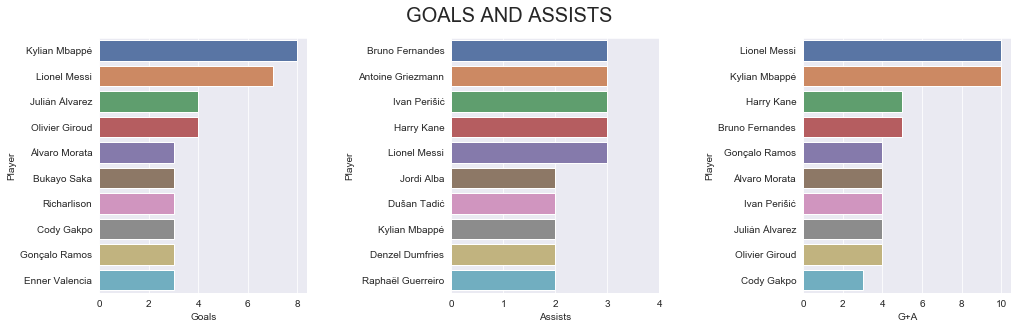

In [39]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('GOALS AND ASSISTS', fontsize=20, )

sn.set_style("darkgrid")

sn.barplot(x="Goals", y="Player", data=most_goals, ax=ax1, palette = 'deep')
sn.barplot(x="Assists", y="Player", data=most_assist, ax=ax2, palette = 'deep')
sn.barplot(x="G+A", y="Player", data=top_goals_plus_assist, ax=ax3, palette = 'deep')
ax2.set(xticks = [0, 1, 2, 3, 4])
plt.tight_layout(pad = 3.8)

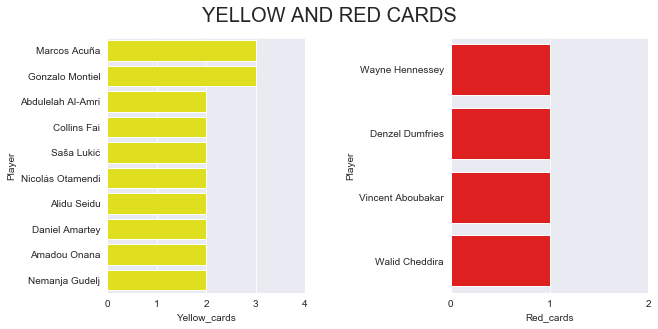

In [42]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('YELLOW AND RED CARDS', fontsize=20, )

sn.set_style("darkgrid")

sn.barplot(x="Yellow_cards", y="Player", data=most_yellow_cards, ax=ax1, color = 'yellow')
sn.barplot(x="Red_cards", y="Player", data=most_red_cards, ax=ax2, color = 'red')
ax1.set(xticks = [0, 1, 2, 3, 4])
ax2.set(xticks = [0, 1, 2])

plt.tight_layout(pad = 3.8)

### 2.3. Analiza poszczególnych statystyk drużyn

In [29]:
stats.head()

,Player,Pos,Squad,Age,Club,Born,MP,Minutes,Goals,Assists,PK,PKatt,Yellow_cards,Red_cards,Sh,SoT,xG
0,Brenden Aaronson,MF,United States,21,1.eng Leeds United,2000,4,108,0,0,0,0,0,0,1,0,0.1
1,Ali Abdi,DF,Tunisia,28,2.fr Caen,1993,3,188,0,0,0,0,1,0,0,0,0.0
2,Salis Abdul Samed,MF,Ghana,22,1.fr Lens,2000,3,250,0,0,0,0,0,0,1,0,0.0
3,Saud Abdulhamid,DF,Saudi Arabia,22,1.sa Al-Hilal,1999,3,270,0,0,0,0,1,0,1,0,0.0
4,Nawaf Al Abed,MF,Saudi Arabia,32,1.sa Al-Shabab,1990,2,88,0,0,0,0,1,0,2,0,0.1


In [30]:
total_stats = stats.groupby('Squad').agg(
    {'MP' : np.max, 'Goals' : np.sum, 'Assists' : np.sum, 'Yellow_cards' : np.sum, 'Red_cards' : np.sum, 'xG' : np.sum})
total_stats.sort_values(['MP','Goals'], ascending = False, inplace = True)
total_stats

,MP,Goals,Assists,Yellow_cards,Red_cards,xG
Squad,,,,,,
France,7,16,12,8,0,14.2
Argentina,7,15,8,17,0,15.5
Croatia,7,8,8,8,0,7.1
Morocco,7,6,4,9,1,6.7
England,5,13,11,1,0,8.9
Portugal,5,12,10,6,0,7.8
Netherlands,5,10,8,12,1,5.2
Brazil,5,8,6,6,0,12.2
Spain,4,9,5,2,0,5.9


In [45]:
most_goals_plus_assists = total_stats[['Goals', 'Assists']]
most_goals_plus_assists['G+A'] = most_goals_plus_assists.eval('Goals + Assists')
most_goals_plus_assists.sort_values('G+A', ascending = False, inplace = True)
most_goals_plus_assists.reset_index(inplace = True)
most_goals_plus_assists.index += 1
most_goals_plus_assists = most_goals_plus_assists[:10]
most_goals_plus_assists

,Squad,Goals,Assists,G+A
1,France,16,12,28
2,England,13,11,24
3,Argentina,15,8,23
4,Portugal,12,10,22
5,Netherlands,10,8,18
6,Croatia,8,8,16
7,Spain,9,5,14
8,Brazil,8,6,14
9,Germany,6,5,11
10,Morocco,6,4,10


In [46]:
most_cards = total_stats[['Yellow_cards', 'Red_cards']]
most_cards['Total_cards'] = most_cards.eval('Yellow_cards + Red_cards')
most_cards.sort_values('Total_cards', ascending = False, inplace = True)
most_cards.reset_index(inplace = True)
most_cards.index += 1
most_cards = most_cards[:10]
most_cards

,Squad,Yellow_cards,Red_cards,Total_cards
1,Argentina,17,0,17
2,Saudi Arabia,14,0,14
3,Netherlands,12,1,13
4,Serbia,11,0,11
5,Morocco,9,1,10
6,Cameroon,8,1,9
7,Switzerland,9,0,9
8,Canada,8,0,8
9,Uruguay,8,0,8
10,Croatia,8,0,8


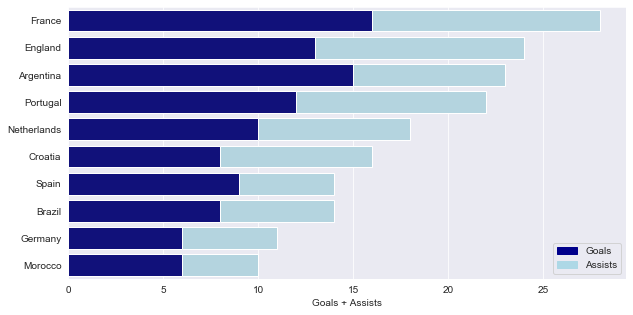

In [67]:
fig = plt.figure(figsize = (10, 5))
bar1 = sn.barplot(x = 'G+A', y = 'Squad', data = most_goals_plus_assists, color = 'lightblue')
bar2 = sn.barplot(x = 'Goals', y = 'Squad', data = most_goals_plus_assists, color = 'darkblue')
plt.xlabel('Goals + Assists')
plt.ylabel('')

light_blue = mpatches.Patch(color='lightblue', label='Assists')
dark_blue = mpatches.Patch(color='darkblue', label='Goals')
plt.legend(handles=[dark_blue, light_blue])

plt.show()

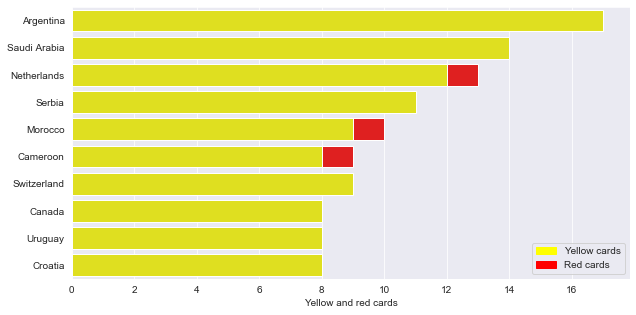

In [70]:
fig = plt.figure(figsize = (10, 5))
bar1 = sn.barplot(x = 'Total_cards', y = 'Squad', data = most_cards, color = 'red')
bar2 = sn.barplot(x = 'Yellow_cards', y = 'Squad', data = most_cards, color = 'yellow')
plt.xlabel('Yellow and red cards')
plt.ylabel('')

yellow = mpatches.Patch(color='yellow', label='Yellow cards')
red = mpatches.Patch(color='red', label='Red cards')
plt.legend(handles=[yellow, red])

plt.show()